In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
data, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
x,y,submission = data["text"],data["target"], test["text"]

In [6]:
def delete_url(regex,data):
    data_no_url = data.apply(lambda x: re.sub(regex," ",x))
    return data_no_url

x_no_url, submission_no_url = delete_url(r"https?://\S+|www\.\S+",x), delete_url(r"https?://\S+|www\.\S+",submission)

In [7]:
def tokenize(data):
    tokenized = [word_tokenize(i) for i in data.values]
    return tokenized

x_tokenized, submission_tokenized = tokenize(x_no_url), tokenize(submission_no_url)

In [8]:
def alphabetic(data):
    alphabetic = [[i for i in j if i.isalpha()] for j in data]
    return alphabetic

x_alpha, submission_alpha = alphabetic(x_tokenized), alphabetic(submission_tokenized)

In [9]:
def delete_stopwords(data):
    no_stopw = [[i for i in j if i not in stopwords.words('english')] if len(j)>1 else j for j in data]
    return no_stopw

x_nostopw, submission_nostopw = delete_stopwords(x_alpha),delete_stopwords(submission_alpha)

In [10]:
def lemmatize(data):
    wnl = WordNetLemmatizer()
    lemma = [[wnl.lemmatize(i) for i in j] for j in data]
    return lemma

x_lemma, submission_lemma = lematize(x_nostopw),lematize(submission_nostopw)

In [11]:
def transform_to_final(data):
    lower = [[i.lower() for i in j] for j in data]
    final = [" ".join(i) for i in lower]
    return final

x_final, submission_final = transform_to_final(x_lemma), transform_to_final(submission_lemma)

In [13]:
x_final[:10]

['our deeds reason earthquake may allah forgive u',
 'forest fire near la ronge sask canada',
 'all resident asked place notified officer no evacuation shelter place order expected',
 'people receive wildfire evacuation order california',
 'just got sent photo ruby alaska smoke wildfire pours school',
 'rockyfire update california hwy closed direction due lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street manitou colorado springs area',
 'i top hill i see fire wood',
 'there emergency evacuation happening building across street',
 'i afraid tornado coming area']

In [13]:
x_count = " ".join(x_final)
x_count = x_count.split()

In [14]:
unique_w = len(set(x_count))

In [15]:
longest_sent = np.max([len(i) for i in x_lower])

In [75]:
tokenizer = Tokenizer(num_words=unique_w)
tokenizer.fit_on_texts(x_final)
sequences, subm_sequences = tokenizer.texts_to_sequences(x_final),tokenizer.texts_to_sequences(submission_final)
seq_padded,subm_seq_padded = pad_sequences(sequences, maxlen=longest_sent, padding='post'),pad_sequences(subm_sequences, maxlen=longest_sent, padding='post')

In [17]:
seq_padded

array([[ 602, 4006,  555, ...,    0,    0,    0],
       [ 119,    5,  172, ...,    0,    0,    0],
       [ 122, 2176, 1436, ...,    0,    0,    0],
       ...,
       [1423,  306,  486, ...,    0,    0,    0],
       [  20, 1007,  278, ...,    0,    0,    0],
       [   2,  147,   94, ...,    0,    0,    0]])

In [43]:
x_train, x_test, y_train, y_test = train_test_split(seq_padded,y,test_size=0.2)

In [59]:
model_7 = Sequential()
model_7.add(Embedding(unique_w+1,100,input_length=len(seq_padded[0])))
#model.add(SimpleRNN(32,activation='relu', input_shape=(len(seq_padded[0]), 64)))
model_7.add(LSTM(64,return_sequences=True))
model_7.add(Dropout(0.5))
model_7.add(LSTM(16,return_sequences=True))
model_7.add(Dropout(0.5))
model_7.add(LSTM(32))
model_7.add(Dropout(0.5))
model_7.add(Dense(1,activation='sigmoid'))
#opt = Adam(learning_rate=0.001)
opt = RMSprop()
ES = EarlyStopping(patience=1)
model_7.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
fit_7 = model_7.fit(x_train,y_train,callbacks=ES,epochs=50,validation_split=0.2)

Epoch 1/50
153/153 [==============================] - 12s 50ms/step - loss: 0.5713 - accuracy: 0.7020 - val_loss: 0.4990 - val_accuracy: 0.7660
Epoch 2/50
153/153 [==============================] - 7s 44ms/step - loss: 0.3826 - accuracy: 0.8506 - val_loss: 0.4660 - val_accuracy: 0.7997
Epoch 3/50
153/153 [==============================] - 7s 44ms/step - loss: 0.2944 - accuracy: 0.8894 - val_loss: 0.5528 - val_accuracy: 0.7931


No handles with labels found to put in legend.


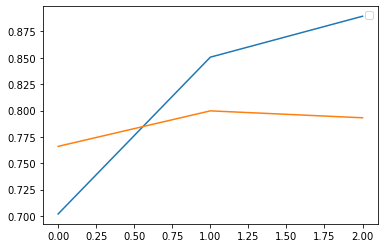

In [60]:
plt.plot(fit_7.history['accuracy'])
plt.plot(fit_7.history['val_accuracy'])
plt.legend()

In [61]:
y_pr = model_7.predict(x_test)
y_cl = [1 if i >= 0.5 else 0 for i in y_pr]
accuracy_score(y_test,y_cl)

0.8063033486539725

In [62]:
model_7.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 27, 100)           1449300   
                                                                 
 lstm_39 (LSTM)              (None, 27, 64)            42240     
                                                                 
 dropout_39 (Dropout)        (None, 27, 64)            0         
                                                                 
 lstm_40 (LSTM)              (None, 27, 16)            5184      
                                                                 
 dropout_40 (Dropout)        (None, 27, 16)            0         
                                                                 
 lstm_41 (LSTM)              (None, 32)                6272      
                                                                 
 dropout_41 (Dropout)        (None, 32)              

In [76]:
subm_pred = model_7.predict(subm_seq_padded)
subm_y = [1 if i >= 0.5 else 0 for i in subm_pred]

In [89]:
subm_y_series = pd.Series(subm_y)
final_submission = pd.concat([test["id"],subm_y_series],axis=1)

In [92]:
final_submission.head()

,id,0
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [99]:
final_submission.to_excel(r"C:\Users\ht323xc\OneDrive - EY\Desktop\kaggle.xlsx")